In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(ascii=True)

from rdkit import Chem
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from scipy.stats import ks_2samp, chisquare,  power_divergence

import tmap, os
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from rdkit import DataStructs, Chem
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.decomposition import PCA
from molmap import dataset
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline
MQN_calculator = lambda x:rdMolDescriptors.MQNs_(Chem.MolFromSmiles(x))

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_valid = pd.read_csv('../data/val.csv')
df_test = pd.read_csv('../data/test.csv')
df_novel = pd.read_csv('../data/bace_chembl_novel.csv')
tasks = 'Class'
# df_etc[tasks] = df_etc.Exp_LogS

In [3]:
len(df_novel)

395

In [4]:
df = df_train.append(df_valid).append(df_test).append(df_novel)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
novel_idx = df.index[-len(df_novel):]
len(train_idx), len(valid_idx), len(test_idx), len(novel_idx)


/home/sxh/anaconda3/envs/rdkit2020/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(1210, 151, 152, 395)

In [5]:
dim = 1024
mols = [Chem.MolFromSmiles(s) for s in df.smiles]
ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]

ecfps = [tmap.VectorUchar(list(fp)) for fp in ECFP4_fps]
enc = tmap.Minhash(dim, seed = 42)

lf = tmap.LSHForest(dim)
lf.batch_add(enc.batch_from_binary_array(ecfps))
lf.index()

100%|##########| 1908/1908 [00:00<00:00, 10605.98it/s]


In [6]:
x, y, s, t, gp = tmap.layout_from_lsh_forest(lf)
X = np.array([x,y]).T


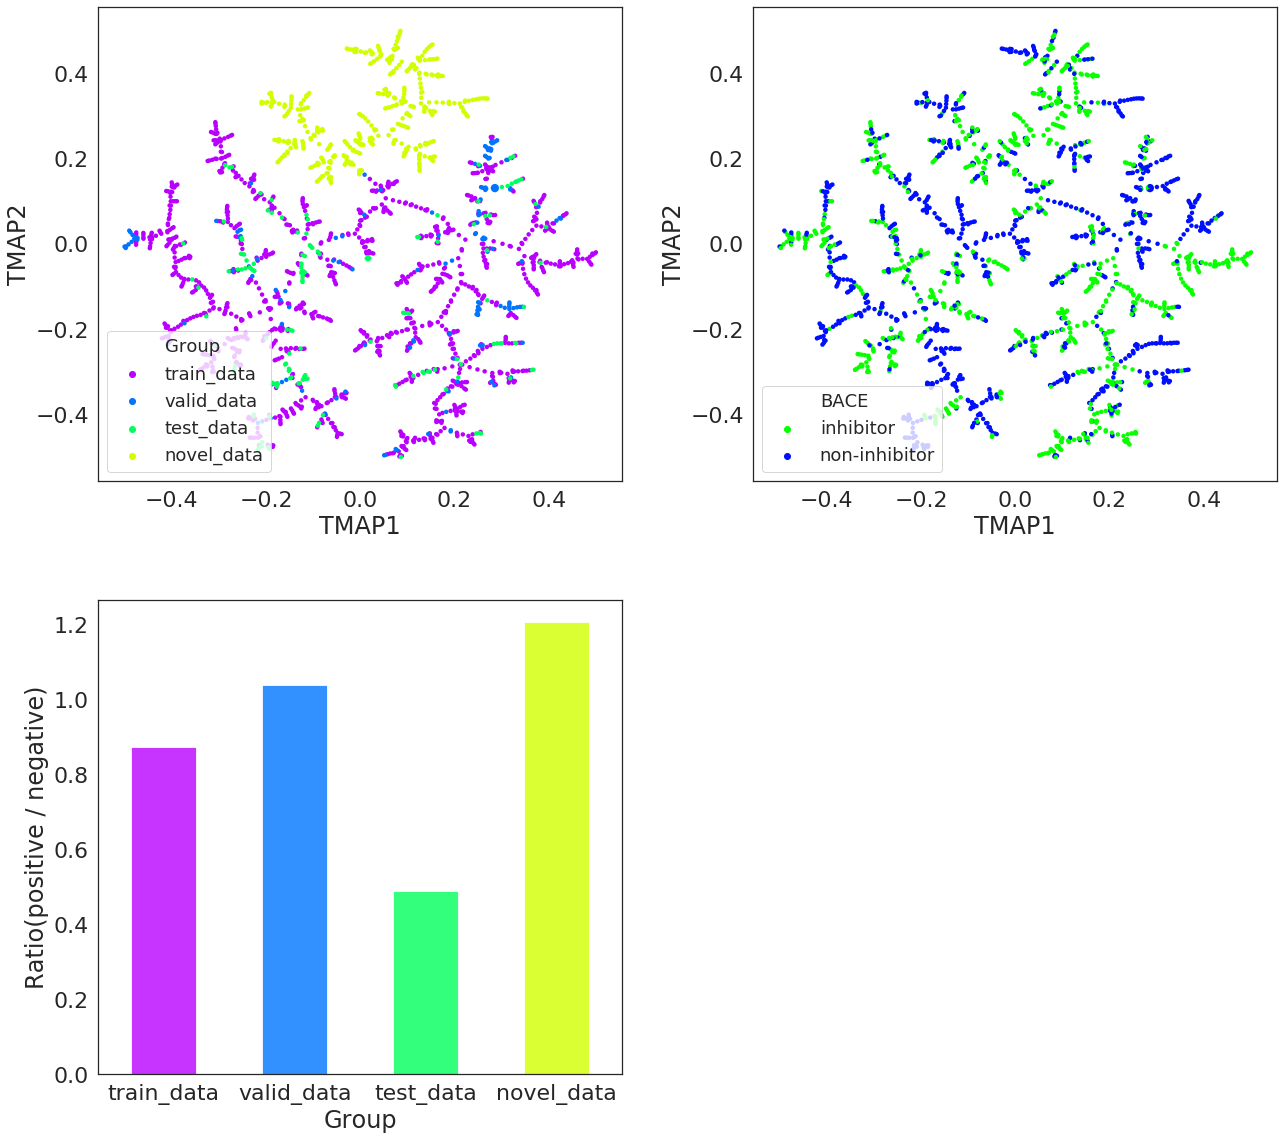

In [7]:
task_name = 'Class'
dft = pd.DataFrame(X, columns = ['TMAP1', 'TMAP2'])
dft[task_name] = df[tasks]
dft['Group'] = np.nan
dft.loc[train_idx, 'Group']= 'train_data'
dft.loc[valid_idx, 'Group']= 'valid_data'
dft.loc[test_idx, 'Group']= 'test_data'
dft.loc[novel_idx, 'Group']= 'novel_data'
dft['smiles'] = df.smiles
branch_name = "Group"

order = [ 'train_data', 'valid_data', 'test_data', 'novel_data', ]

data_save_folder = './'

sns.set(style='white', font_scale = 2)
size = 20
palette = sns.color_palette("hsv_r", 4)


fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18,16))
(ax1, ax3), (ax2, ax4) = axes


sns.set(style="white")

_ = sns.scatterplot('TMAP1', 'TMAP2',  hue = "Group", palette = "hsv_r",  hue_order = order, s = size, #alpha = 0.5,
                    data = dft, ax = ax1, linewidth = 0)
ax1.legend(loc='upper right')


dft[task_name] = dft[task_name].map({0:'non-inhibitor', 1:'inhibitor'})
order = ['inhibitor', 'non-inhibitor']

dft['BACE'] = dft.Class
_ = sns.scatterplot('TMAP1', 'TMAP2',  hue = 'BACE', palette = "hsv",  hue_order = order, s = size, 
                    data = dft, ax = ax3, linewidth = 0)

ax3.set_xlabel('TMAP1')
ax3.set_ylabel('TMAP2')

# lg3 = ax3.legend(*im3.legend_elements(num = 1), loc="upper right", title=task_name,)
# ax3.add_artist(lg3)

# ax3.add_artist(lg3)
# lg3.set_title(task_name,prop={'size':18})

ax1.legend(fontsize=18, loc = 'lower left') 
ax3.legend(fontsize=18, loc = 'lower left') 



gb = dft.groupby(["Group", "Class"]).size().unstack()


gbb = gb['inhibitor']/gb['non-inhibitor']
gbb = gbb.loc[['train_data', 'valid_data', 'test_data', 'novel_data']]

gbb.plot(kind = 'bar', color  = palette,  ax= ax2, rot=0, alpha = 0.8, )
ax2.set_ylabel('Ratio(positive / negative)')
#ax2.set_xticklabels()
ax4.set_axis_off()


fig.show()
plt.close(2)
fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)

fig.savefig(os.path.join(data_save_folder, 'chem_space.svg'), dpi=300, format='svg')

In [8]:
dft['BACE'] = dft.Class.map({'inhibitor': 1., 'non-inhibitor': 0.})
df = dft
branch_name = 'Group'
task_name = 'BACE'

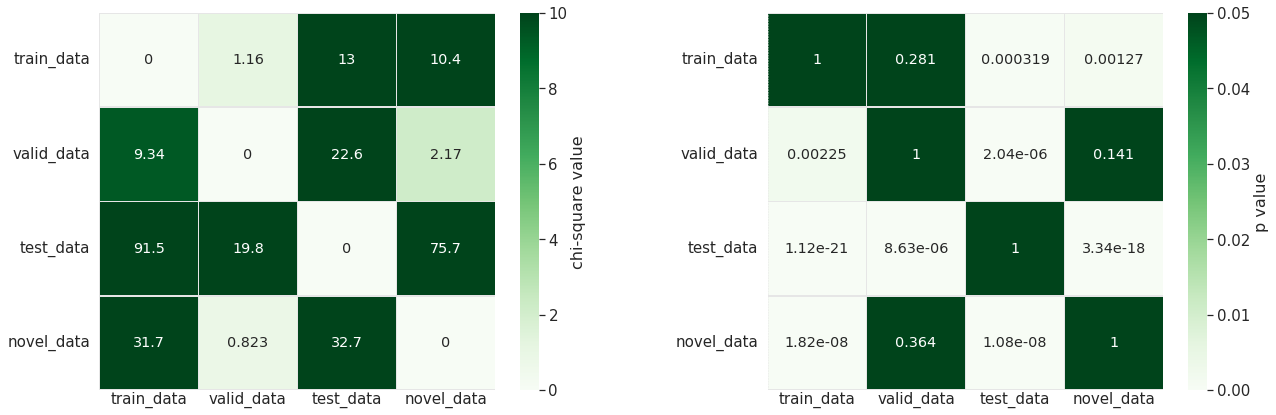

In [14]:
sns.set(style='white', font_scale = 1.2)
fig, axes = plt.subplots(ncols=2,figsize=(18,6))
ax1, ax2,  = axes

fontsize = 16


gb = df.groupby([branch_name, task_name]).size().unstack()
gb.columns = gb.columns.astype(int)
gb = gb.loc[['train_data', 'valid_data', 'test_data', 'novel_data']]

chisq_values = []
p_values = []
for i in gb.index:
    for j in gb.index:
        expected = gb.loc[i].values
        observed = gb.loc[j].values
        # adjust the number of the expected
        expected_adjust = (expected / expected.sum()) * observed.sum()

        chisq, p = chisquare(expected_adjust, observed)
        chisq_values.append(chisq)
        p_values.append(p)

arrv = np.array(chisq_values).reshape(len(gb), len(gb)).astype('float16')
arrp = np.array(p_values).reshape(len(gb), len(gb))
dfv = pd.DataFrame(arrv, index = gb.index, columns = gb.index)
dfp = pd.DataFrame(arrp, index = gb.index, columns = gb.index)

vax = sns.heatmap(dfv, vmax = 10, annot=True, cmap = 'Greens', fmt='.3g',  ax = ax1,
                 linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'chi-square value'})
vax.figure.axes[-1].yaxis.label.set_size(fontsize)
vax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size

pax = sns.heatmap(dfp, vmax = 0.05, annot=True, cmap = 'Greens', fmt='.3g',  ax= ax2,
                 linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'p value',})
pax.figure.axes[-1].yaxis.label.set_size(fontsize)
pax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size    

    
for ax in [ax1, ax2]:
    ax.set_yticklabels(dfv.index, rotation=0, fontsize="15", va="center")
    ax.set_xticklabels(dfv.index, rotation=0, fontsize="15", va="center")
    ax.axhline(y=0, color='0.9',lw= 0.5, ls =  '--')
    ax.axhline(y=dfv.shape[0], color='0.9',lw= 0.5, ls =  '--')
    ax.autoscale()
    ax.axvline(x=dfv.shape[1], color='0.9',lw= 0.5, ls =  '--')  
    ax.axvline(x=0, color='0.9',lw= 0.5, ls =  '--')
    ax.set_xlabel('', fontsize = 16)
    ax.set_ylabel('', fontsize = 16)

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)

fig.savefig(os.path.join(data_save_folder, '%s_stat_test.svg' % task_name), dpi=300, format='svg')

dfv['Value'] = 'statistic value'
dfv = dfv.reset_index().set_index(['Value', 'Group'])
dfp['Value'] = 'p value'
dfp = dfp.reset_index().set_index(['Value', 'Group'])
dfv.append(dfp).to_excel(os.path.join(data_save_folder, '%s_stat_test.xlsx' % task_name))

In [11]:
dft

,TMAP1,TMAP2,Class,Group,smiles,BACE
0,0.003323,-0.205332,inhibitor,train_data,Fc1cc(cc(F)c1)C[C@H](NC(=O)c1c2cccnc2n(c1)C(=O...,1.0
1,0.007980,-0.210269,inhibitor,train_data,Fc1cc(cc(F)c1)C[C@H](NC(=O)c1c2cccnc2n(c1)C(=O...,1.0
2,0.117718,-0.218851,inhibitor,train_data,Fc1cc(cc(F)c1)C[C@H](NC(=O)c1cc(cc(c1)C)C(=O)N...,1.0
3,-0.304186,0.236972,non-inhibitor,train_data,Clc1ccc(nc1)C(=O)Nc1cc2c(CCC23N=C(OC3)N)cc1,0.0
4,-0.280490,0.075102,non-inhibitor,train_data,Fc1ccc(cc1)Cc1cc(ccc1)C1([NH+]=C(N2C1=NCCC2)N)...,0.0
...,...,...,...,...,...,...
1903,0.031175,0.266380,inhibitor,novel_data,COC1CCC2(CC1)Cc1ccc(-c3cncc(F)c3)cc1C21N=C(N)N...,1.0
1904,0.020560,0.241451,inhibitor,novel_data,COC1CCC2(CC1)Cc1ccc(-c3cncc(Cl)c3)cc1C21N=C(N)...,1.0
1905,0.093789,0.208891,non-inhibitor,novel_data,CO[C@H]1CC[C@]2(CC1)Cc1c(F)cccc1C21N=C(N)N(C)C1=O,0.0
1906,-0.054501,0.205067,inhibitor,novel_data,COC1CCC2(CC1)Cc1ccc(-c3cc(F)cc(C#N)c3)cc1C21N=...,1.0


In [12]:
# Now plot interactive results

categorical = [True, True,]
    
faerun = Faerun(view="front", clear_color='#111111',coords=False) #'#ffffff'
faerun.add_scatter(
    task_name,
    {   "x": x, 
        "y": y, 
        "c": [dft.Class.map({'inhibitor': 1., 'non-inhibitor': 0.}).values, 
              dft.Group.map({'train_data':0, 'valid_data':1, 'test_data':2, 'novel_data':3}).tolist()],
        "labels": dft.smiles.tolist()},
    point_scale=5,
    colormap = ['rainbow', 'tab10'],
    has_legend=True,
    categorical = categorical,
    series_title = ['BACE', 'Group'],
    legend_labels = [None, None],
    shader = 'smoothCircle'
)

faerun.add_tree(task_name + "_tree", {"from": s, "to": t}, point_helper=task_name,  color='#666666', ) #colors when no value

# Choose the "smiles" template to display structure on hover
faerun.plot('BACE', path = data_save_folder, template="smiles", notebook_height=750)

/home/sxh/Research/bidd-molmap/paper/07_BACE_HPs/03_chemical_space/BACE.html